In [1]:
# Import necessary libraries
import os                        # Library to interact with the operating system
import cv2                       # OpenCV library for computer vision tasks
import numpy as np               # NumPy library for numerical operations
from sklearn.datasets import fetch_lfw_people   # Function to load the LFW dataset
from sklearn.model_selection import train_test_split   # Function to split dataset into train and test subsets

# Function to split augmented dataset into training and testing subsets
def split_augmented_dataset(augmented_dir, test_size=0.2):
    # Get the list of label names (subdirectories in augmented_dir)
    label_names = os.listdir(augmented_dir)   # Fetch the names of subdirectories in the augmented dataset
    images = []   # Initialize an empty list to store images
    labels = []   # Initialize an empty list to store corresponding labels

    # Loop through each label and read images from subdirectories
    for label_idx, label_name in enumerate(label_names):
        label_dir = os.path.join(augmented_dir, label_name)   # Create the full path of the label subdirectory
        for image_file in os.listdir(label_dir):   # Loop through each image file in the subdirectory
            image_path = os.path.join(label_dir, image_file)   # Create the full path of the image file
            image = cv2.imread(image_path)   # Read the image using OpenCV
            images.append(image)   # Append the image to the images list
            labels.append(label_idx)   # Append the corresponding label to the labels list

    images = np.array(images)   # Convert the list of images to a NumPy array
    labels = np.array(labels)   # Convert the list of labels to a NumPy array

    # Split the images and labels into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)   # Split using sklearn's train_test_split
    return X_train, X_test, y_train, y_test   # Return the training and testing subsets of images and labels

In [2]:
# Function to perform image augmentation using OpenCV
def augment_image(image):
    # Check if the image is grayscale (2-dimensional)
    if image.ndim == 2:  # Grayscale image
        # Convert the grayscale image to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    rows, cols, _ = image.shape   # Get the dimensions of the image

    # Random rotation between -10 to 10 degrees
    random_angle = np.random.randint(-10, 11)   # Generate a random angle between -10 and 10 degrees
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), random_angle, 1)   # Get the rotation matrix for the random angle
    augmented_image = cv2.warpAffine(image, M, (cols, rows))   # Apply the rotation to the image using warpAffine

    # Random horizontal flipping
    if np.random.rand() > 0.5:   # Generate a random number between 0 and 1, and check if it's greater than 0.5
        flipped_image = cv2.flip(augmented_image, 1)  # 1 means horizontal flip. Flip the image horizontally
    else:
        flipped_image = augmented_image   # Keep the image as is (no horizontal flip)

    # Random brightness adjustment
    brightness_factor = np.random.uniform(0.7, 1.3)   # Generate a random brightness factor between 0.7 and 1.3
    hsv_image = cv2.cvtColor(flipped_image, cv2.COLOR_RGB2HSV)   # Convert the RGB image to HSV color space
    hsv_image[:, :, 2] = hsv_image[:, :, 2] * brightness_factor   # Adjust the brightness (V channel) by the brightness factor
    augmented_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)   # Convert the HSV image back to RGB color space

    return augmented_image   # Return the augmented image

In [3]:
def augment_lfw_people_dataset(lfw_people, target_count=10, output_directory='lfw_augmented'):
    # Create a new directory for the augmented dataset
    augmented_dir = os.path.join(lfw_people.target_names[0], output_directory)   # Create the full path of the augmented directory
    os.makedirs(augmented_dir, exist_ok=True)   # Create the augmented directory if it doesn't exist

    # Loop through each label in the dataset
    for label_idx, label_name in enumerate(lfw_people.target_names):
        label_dir = os.path.join(augmented_dir, label_name)   # Create the full path of the label subdirectory
        os.makedirs(label_dir, exist_ok=True)   # Create the label subdirectory if it doesn't exist

        # Get images belonging to the current label
        label_images = lfw_people.images[lfw_people.target == label_idx]   # Fetch the images with the current label

        # Check if the label folder already has enough images (>= target_count)
        if len(label_images) >= target_count:   # If the label already has enough images
            selected_images = label_images[:target_count]   # Select the first target_count number of images
        else:
            # If the label folder has fewer images, duplicate and augment the existing images
            selected_images = []
            while len(selected_images) < target_count:
                for image in label_images:
                    selected_images.append(augment_image(image))   # Augment the image and add to selected_images
                    if len(selected_images) == target_count:   # Check if we have enough augmented images
                        break

        # Perform augmentation for images with count < target_count
        for idx, image in enumerate(selected_images):
            image_path = os.path.join(label_dir, f'{label_name}_{idx}.png')   # Create the full path of the augmented image
            cv2.imwrite(image_path, image)   # Write the augmented image to the specified path

In [4]:
# Load the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=1, resize=0.4)   # Fetch the LFW dataset with specified parameters

# Augment the LFW dataset
augment_lfw_people_dataset(lfw_people, target_count=10)   # Augment the dataset with 10 images per class

# Split the augmented dataset into training and testing subsets
augmented_dir = os.path.join(lfw_people.target_names[0], 'lfw_augmented')   # Create the full path of the augmented directory
X_train, X_test, y_train, y_test = split_augmented_dataset(augmented_dir, test_size=0.2)   # Split the dataset into train and test subsets


In [5]:
import matplotlib.pyplot as plt

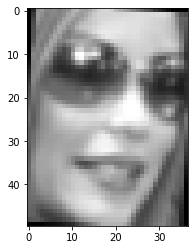

In [6]:
image = plt.imread("./AJ Cook/lfw_augmented/Angie Martinez/Angie Martinez_4.png")
plt.imshow(image)

In [ ]:
import os
from sklearn.datasets import fetch_lfw_people

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score



# Convert the labels to one-hot encoded format (categorical)
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Normalize the pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 37, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 40
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_labels)


2023-08-02 20:19:30.461429: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/40
1150/1150 [==============================] - 44s 38ms/step - loss: 8.6736 - accuracy: 5.4358e-05 - val_loss: 8.6336 - val_accuracy: 4.3483e-04
Epoch 2/40
 726/1150 [=================>............] - ETA: 15s - loss: 8.4960 - accuracy: 9.4697e-04

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy * 100))

In [ ]:
classification_report_str = classification_report(y_test, y_pred_labels, target_names=y_train)
print("Classification Report:")
print(classification_report_str)